<a href="https://colab.research.google.com/github/yasohasakii/unet-segmentation/blob/master/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf *
!git clone https://github.com/yasohasakii/unet-segmentation.git
!cp -r unet-segmentation/* ./
!rm -rf unet-segmentation/

Cloning into 'unet-segmentation'...
remote: Enumerating objects: 336, done.
remote: Total 336 (delta 0), reused 0 (delta 0), pack-reused 336
Receiving objects: 100% (336/336), 674.32 MiB | 36.04 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Checking out files: 100% (264/264), done.


In [2]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K
from keras.losses import binary_crossentropy
from PIL import Image

Using TensorFlow backend.


In [0]:
#metrics were from https://www.kaggle.com/meaninglesslives/unet-plus-plus-with-efficientnet-encoder
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [4]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    b = keras.layers.BatchNormalization()(c)
    d = keras.layers.Dropout(0.25)(b)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(d)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c
def UNet(h=1024,w=1024):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((h, w, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #1024 -> 512
    c2, p2 = down_block(p1, f[1]) #512 -> 256
    c3, p3 = down_block(p2, f[2]) #256 -> 128
    c4, p4 = down_block(p3, f[3]) #128 -> 64
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #64 -> 128
    u2 = up_block(u1, c3, f[2]) #128 -> 256
    u3 = up_block(u2, c2, f[1]) #256 -> 512
    u4 = up_block(u3, c1, f[0]) #512 -> 1024
    
    out = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    outputs = keras.layers.Reshape((h, w))(out)
    model = keras.models.Model(inputs, outputs)
    return model

model = UNet()

model.compile(optimizer=Adam(lr=0.0001), loss=bce_dice_loss, metrics=[my_iou_metric])
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model_1"
______________________________________________________________________________________

In [0]:
class DataGen(keras.utils.Sequence):
    def __init__(self, path, batch_size=1, image_size=1024):
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        files = os.listdir(self.path)
        files = [os.path.join(self.path,x) for x in files]
        self.trains, self.vals = train_test_split(files, test_size=0.1, random_state=42)
    
    def generate(self,files): 
        random.shuffle(files)
        while True:
            image_batch = np.zeros([self.batch_size,self.image_size,self.image_size,3])
            label_batch = np.zeros([self.batch_size,self.image_size,self.image_size])
            index = random.randint(0,len(files)-self.batch_size)
            for i,img in enumerate(files[index:index+self.batch_size]):
                rotate_angle = random.randint(0,180)
                shift_width = random.randint(0,102)
                shift_height = random.randint(0,102)
        
                ## Reading Image
                _image = Image.open(img)
                _image = _image.rotate(rotate_angle)
                _image = _image.resize((self.image_size, self.image_size))
                _image = np.array(_image)
                image = np.zeros([self.image_size,self.image_size,3],np.uint8)
        
                _mask_image = Image.open(img.replace('raw','label'))
                _mask_image = _mask_image.convert('L')
                _mask_image = _mask_image.rotate(rotate_angle)
                _mask_image = _mask_image.resize((self.image_size, self.image_size))
                _mask_image = np.array(_mask_image)
                mask = np.zeros([self.image_size,self.image_size],np.uint8)

                image[shift_height:,shift_width:,:] = np.array(_image)[:self.image_size-shift_height,:self.image_size-shift_width,:]
                mask[shift_height:,shift_width:] = np.array(_mask_image)[:self.image_size-shift_height,:self.image_size-shift_width] 
                
                ## Normalizaing 
                image = image/255.0
                mask = mask/255.0

                image_batch[i] = image
                label_batch[i] = mask                   
        
            yield image_batch, label_batch

In [0]:
train_path = '/content/raw'
batch_size= 1
gen = DataGen( train_path, image_size=1024, batch_size=batch_size)
train_gen = gen.generate(gen.trains)
val_gen = gen.generate(gen.vals)


train_steps = len(gen.trains)//batch_size
valid_steps = len(gen.vals)//batch_size

In [0]:
model_checkpoint = ModelCheckpoint('unet.h5', monitor='val_my_iou_metric',mode='max',verbose=1,save_best_only=True,save_weights_only=True)
changelr = ReduceLROnPlateau(monitor = 'val_my_iou_metric',
                patience=5,mode = 'max',
                verbose = 1,
                factor = 0.3,
                min_lr = 0.000001)
h = model.fit_generator(train_gen,steps_per_epoch=train_steps,epochs=30,
                    callbacks=[model_checkpoint,changelr],
                    validation_data = val_gen,validation_steps = valid_steps)



Epoch 1/30
108/108 [==============================] - 72s 667ms/step - loss: 1.3233 - my_iou_metric: 0.0463 - val_loss: 1.4262 - val_my_iou_metric: 0.0000e+00

Epoch 00001: val_my_iou_metric improved from -inf to 0.00000, saving model to unet.h5
Epoch 2/30
108/108 [==============================] - 55s 508ms/step - loss: 1.1506 - my_iou_metric: 0.1176 - val_loss: 1.2353 - val_my_iou_metric: 0.0000e+00

Epoch 00002: val_my_iou_metric did not improve from 0.00000
Epoch 3/30
 52/108 [=============>................] - ETA: 27s - loss: 1.0915 - my_iou_metric: 0.1442

/content/test/5221cf979fe645959c6e45e523092145.png


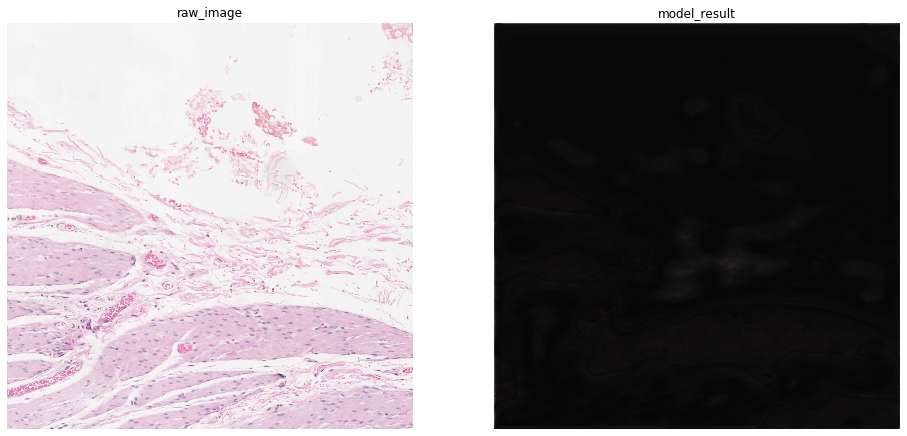

/content/test/09816413ea8f42d88479f300d689fb51.png


KeyboardInterrupt: ignored

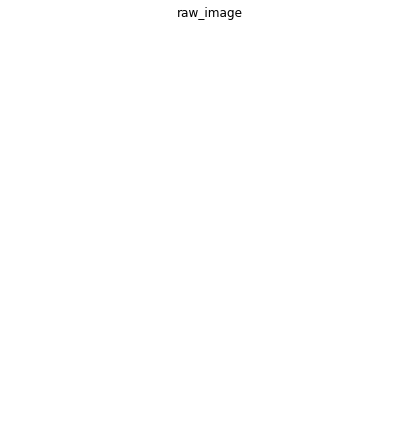

In [15]:
from PIL import Image
import glob, cv2
import matplotlib.pyplot as plt
%matplotlib inline

model.load_weights('/content/unet.h5')

def predict(model,image):
    image = np.array(image,np.float)/255.0
    image = np.expand_dims(image,axis=0)
    pred = model.predict(image)[0]
    # pred = (pred-np.min(pred))/(np.max(pred)-np.min(pred))
    pred = cv2.merge([pred,pred,pred])
    return pred

def plot_result(model,img):
    image = Image.open(img)
    h,w = image.size
    copy = image.resize((1024,1024))
    copy = np.array(copy,np.float)
    pred = predict(model,copy)
    pred = cv2.resize(pred,(h,w))
    blend = np.array(image)*pred
    blend = np.asarray(blend,np.uint8)
    return blend
    

if __name__ == '__main__':
    images = glob.glob('/content/test/*.png')
    for image in images:
        print(image)
        result = plot_result(model,image)
        _image = np.array(Image.open(image))
    
        plt.figure(figsize=(16,8))
        plt.subplot(121)
        plt.title('raw_image')
        plt.axis('off') 
        plt.imshow(_image)

        plt.subplot(122)
        plt.title('model_result')
        plt.axis('off') 
        plt.imshow(result)
        plt.show()